### INSIGHTS
- распределение по возрасту, просадка в промежутке 20-50

### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import pickle
import requests, zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict
import itertools

### EXTRACT

In [17]:
z = zipfile.ZipFile('krugki.zip')
z.extractall()

### DOWNLOAD

In [107]:
df_classes = pd.read_csv('Classificator_hachaton.csv', delimiter=';')
df_org = pd.read_csv('org_hackaton.csv', delimiter=';') # Список КЦ # дубликаты одинаковые КЦ с разным метро
df_pupil = pd.read_csv('Pupil_hackaton.csv', delimiter=';') # пользователи КЦ
df_req = pd.read_csv('request_hackaton.csv', delimiter=';')
df_services = pd.read_csv('services_hackaton.csv', delimiter=';')
df_relation = pd.read_csv('MegaRelation_hackaton.csv', delimiter=';')

### PREPROCESSING

##### df_classes
- матчми классы
- корректируем род_класс и класс
- заполняем наны

In [108]:
class_nan = df_classes['id_родительского_классификатора'].isna()
df_classes.loc[class_nan, 'id_родительского_классификатора'] = df_classes.loc[class_nan, 'id_классификатора'] 
df_classes.loc[class_nan, 'id_классификатора'] = np.nan
df_classes['id_родительского_классификатора'] = df_classes['id_родительского_классификатора'].astype(int)
df_classes = df_classes.sort_values(['id_классификатора'])

# матчим названия
id_classes = {
    'Цирковое искусство': 'Искусство цирка',
    'Изобразительное искусство': 'ИЗО',
    'Хореографическое искусство' : 'Хореографическое творчество',
    'Раннее развитие': 'Раннее эстетическое развитие',
}

df_classes['Наименование'] = df_classes['Наименование'].replace(id_classes)
df_classes = df_classes.groupby(['id_родительского_классификатора', 'Наименование']).apply(lambda x: x['id_классификатора'].fillna(method='ffill')).reset_index()
df_classes = df_classes.drop(['level_2'], axis=1)

# допущение, что возможная ошибка в id, приравниваем род_классификатор и классификатор
df_classes.loc[df_classes['id_классификатора'].isna(), 'id_классификатора'] = df_classes.loc[df_classes['id_классификатора'].isna(), 'id_родительского_классификатора']
df_classes['id_классификатора'] = df_classes['id_классификатора'].astype(int)
df_classes = df_classes[~df_classes.duplicated()].reset_index(drop=True)

##### df_org
- заполняем наны
- приводим к уникальному id

In [109]:
df_org['Метро'] = df_org['Метро'].fillna('Нет')
df_org['улица'] = df_org['улица'].fillna('Нет')
df_org['Метро'] = df_org['Метро'].str.split('\(', expand=True)[0]
df_org['Метро'] =  df_org.groupby('id_организации')['Метро'].transform(lambda x: ', '.join(x))
df_org = df_org.drop_duplicates(['id_организации'])

##### df_pupil
- фикс отрицательного возраста
- cut 90+
- fillna

In [110]:
df_pupil.loc[df_pupil['id_ученика'] == 920894, 'возраст'] = abs(df_pupil.loc[df_pupil['id_ученика'] == 920894, 'возраст'])
df_pupil.loc[df_pupil['id_ученика'] == 920981, 'возраст'] = df_pupil.loc[df_pupil['id_ученика'] == 920981, 'возраст'] + 1000
df_pupil.loc[df_pupil['id_ученика'] == 931529, 'возраст'] = df_pupil.loc[df_pupil['id_ученика'] == 931529, 'возраст'] + 1000
df_pupil.loc[df_pupil['id_ученика'] == 938810, 'возраст'] = df_pupil.loc[df_pupil['id_ученика'] == 938810, 'возраст'] + 1000
df_pupil.loc[df_pupil['id_ученика'] == 2667143, 'возраст'] = abs(df_pupil.loc[df_pupil['id_ученика'] == 2667143, 'возраст'])
df_pupil.loc[df_pupil['возраст'] > 90, 'возраст'] = 90
df_pupil['возраст'] = df_pupil['возраст'].fillna(int(df_pupil['возраст'].mean()))
df_pupil['возраст'] = df_pupil['возраст'].astype(int)

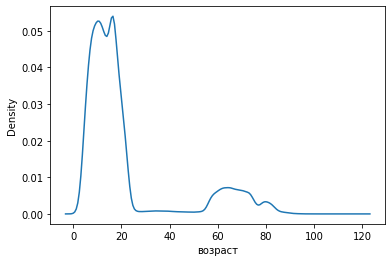

In [6]:
sns.kdeplot(df_pupil['возраст'])

##### df_req
- конвертация времени

In [111]:
df_req['дата_создания'] = pd.to_datetime(df_req['дата_создания'])

/home/jupyter/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


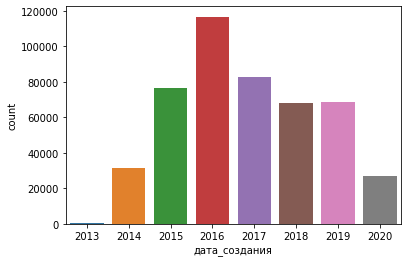

In [362]:
sns.countplot(df_req['дата_создания'].dt.year)

##### df_services
- дропнуть лишние записи (нет классификатора)

In [112]:
df_services['Дата_создания'] = pd.to_datetime(df_services['Дата_создания'])
df_services = df_services[df_services['Классификатор_услуги'].isin(np.unique(df_classes['id_классификатора']))]
df_services['длительность_обучения'] = df_services['длительность_обучения'].fillna('1,0000')
df_services['длительность_обучения'] = df_services['длительность_обучения'].apply(lambda x: int(x.split(',')[0]))
len_match = {
    'лет': 365,
    'месяцев': 12,
    'недель': 7,
    'дней': 1,
}
df_services['длительность_обучения'] = df_services['длительность_обучения'] * df_services['единица_длительности'].replace(len_match)

##### df_relation
- дропнуть учеников с нанами

In [113]:
df_relation = df_relation[~df_relation['id_ученика'].isna()]
df_relation['id_ученика'] = df_relation['id_ученика'].astype(int)
df_relation['Статус'] = df_relation['Статус'].astype(int)
df_relation['Дата_создания_записи'] = pd.to_datetime(df_relation['Дата_создания_записи'])
# df_relation['дата_зачисления'] = pd.to_datetime(df_relation['дата_зачисления'])
df_relation['дата_отчисления'] = pd.to_datetime(df_relation['дата_отчисления'])
# df_relation['Плановая_дата_начала_занятий'] = pd.to_datetime(df_relation['Плановая_дата_начала_занятий'])
# df_relation['Плановая_дата_окончания_занятий'] = pd.to_datetime(df_relation['Плановая_дата_окончания_занятий'])

### CREATE DATASET

##### COSINE

In [28]:
from scipy.sparse import csc_matrix
from sklearn.metrics.pairwise import cosine_distances

In [114]:
df = df_relation.loc[:, ['id_ученика', 'id_услуги']].merge(df_services.loc[:, ['id_услуги', 'Классификатор_услуги']], on=['id_услуги']).loc[:, ['id_ученика', 'Классификатор_услуги']]

df['count'] = 1
df = df.groupby(['id_ученика', 'Классификатор_услуги'])['count'].count().reset_index()
# class_serv_to_id  = {y: x for x, y in enumerate(df['Классификатор_услуги'].sort_values().unique())}
# class_id_to_serv = {y: x for x, y in class_serv_to_id.items()}
# pupil_serv_to_id  = {y: x for x, y in enumerate(df['id_ученика'].sort_values().unique())}
# pupil_id_to_serv = {y: x for x, y in pupil_serv_to_id.items()}
# df['Классификатор_услуги'] = df['Классификатор_услуги'].map(class_serv_to_id)
# df['id_ученика'] = df['id_ученика'].map(pupil_serv_to_id)

M = csc_matrix((df['count'].astype(int).values,
               (df['id_ученика'].astype(int).values, df['Классификатор_услуги'].astype(int).values)))

# M = csc_matrix(([1] * len(df),
#                (df['id_ученика'].astype(int).values, df['Классификатор_услуги'].astype(int).values)))

In [186]:
def get_predicts(user_id: int, n: int) -> List[int]:
    class_ids = []
    with open('cosine_sim', 'rb') as f:
        M = pickle.load(f)
    age = df_pupil.loc[df_pupil['id_ученика'] == user_id, 'возраст'].values[0]
    if user_id in df_relation['id_ученика'].values:
        dist = cosine_distances(M, M[user_id]).reshape(-1, )
    else:
#         age = df_pupil.loc[df_pupil['id_ученика'] == user_id, 'возраст'].values[0]
        new_user_id = df_pupil.loc[(df_pupil['возраст'] == age), ['id_ученика']].values.reshape(-1, )[0]
        dist = cosine_distances(M, M[new_user_id]).reshape(-1, )
    for classif in dist.argsort()[-200:][::-1]:
        try:
            class_ids.append(df.loc[df['id_ученика'] == classif, 'Классификатор_услуги'].values[0])
        except:
            continue
    seen = set()
    seen.add(3003269)
    uniq = []
    for x in class_ids:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
    return uniq[1:n+1]

In [187]:
ids = get_predicts(138, 5)

In [181]:
ids

[3220801, 3220508, 3003430, 3003485, 3003226]

In [190]:
def get_krugki(ids: List[int]) -> List[int]:
    kr = []
    for i in ids:
        kr.append(df_services.loc[(df_services['Дата_создания'] > '2020-01-01') & (df_services['Классификатор_услуги'] == i), 'id_услуги'].values.reshape(-1, )[0])
    return kr

In [191]:
get_krugki(ids)

[1012820, 1010176, 1018172, 1010006, 1066487]

In [197]:
df_services[(df_services['Дата_создания'] > '2020-01-01') & (df_services['id_услуги'] == 1066487)]

,id_услуги,Тип_финансирования,Классификатор_услуги,id_организации,Тип_расписания,Наименование_услуги,Дата_создания,длительность_обучения,единица_длительности
8680,1066487,бесплатно,3003226,10880,Общее,"""Родничок""",2020-06-23 10:41:01,108.0,месяцев


In [73]:
np.intersect1d(df['id_ученика'].values, get_predicts(155319, 10)

array([1520746., 1520748., 4537121.])

In [118]:
df_pupil[df_pupil['возраст'] > 50]

,id_ученика,возраст,пол
103,106,90,Женский
135,138,90,Женский
139,142,90,Женский
150,153,90,Женский
157,160,90,Женский
...,...,...,...
2742558,4537208,72,Женский
2742560,4537214,77,Женский
2742563,4537220,82,Мужской
2742564,4537223,70,Женский


In [85]:
df_pupil[df_pupil['id_ученика'] == 155319]

,id_ученика,возраст,пол
101114,155319,10,Женский


In [86]:
df_pupil[df_pupil['id_ученика'] == 1251881]

,id_ученика,возраст,пол
1122276,1251881,31,Мужской


In [13]:
def get_predicts(user_id: int, n: int) -> Dict[str, List[int]]:
    class_ids = []
    with open('cosine_sim', 'rb') as f:
        M = pickle.load(f)
    try: 
        new_user_id = pupil_serv_to_id[user_id]
        dist = cosine_distances(M, M[new_user_id]).reshape(-1, )
    except:
        age = df_pupil.loc[df_pupil['id_ученика'] == user_id, 'возраст'].values[0]
        new_user_id = df_pupil.loc[(df_pupil['id_ученика'].isin(pupil_id_to_serv.values())) & (df_pupil['возраст'] == age), ['id_ученика']].values.reshape(-1, )[0]
#         return new_user_id
        new_user_id = pupil_serv_to_id[new_user_id]
        dist = cosine_distances(M, M[new_user_id]).reshape(-1, )
    for classif in dist.argsort()[-10:][::-1]:
        class_ids.append(class_id_to_serv[df.loc[df['id_ученика'] == classif, 'Классификатор_услуги'].values[0]])
    if df_pupil.loc[df_pupil['id_ученика'] == new_user_id, 'возраст'].values[0] > 7:
        class_ids = [x for x in class_ids if x != 3003269]
    class_ids = list(set(class_ids))
    return class_ids[1:n+1]

In [330]:
df_pupil.loc[df_pupil['id_ученика'] == 1251881, 'возраст'].values[0] > 7

True

In [320]:
df_classes[df_classes['id_классификатора'] == 3220508]

,id_родительского_классификатора,Наименование,id_классификатора
524,3220500,Гитара,3220508


In [264]:
df_pupil[df_pupil['id_ученика'] == 30220]

,id_ученика,возраст,пол
24121,30220,19.0,Мужской


In [262]:
df_relation['id_ученика'][12346]

30220

In [306]:
df_relation['id_ученика'][234124]

1251881.0

In [202]:
df_relation[df_relation['id_ученика'] == 25969]

,id_зачисления,Статус,id_ученика,Дата_создания_записи,id_организации,id_заявления,id_услуги,дата_зачисления,дата_отчисления,причина_перевода,предыдущая_запись_зачисления,следующая_запись_зачисления,Плановая_дата_начала_занятий,Плановая_дата_окончания_занятий
0,1325954,3,25969,2015-08-06 14:47:19,30,950832.0,39178,08.06.2015 0:00:00,2016-02-29 19:28:12,NaN,NaN,3558114.0,01.09.2014 0:00:00,01.09.2021 0:00:00
22705,44262,2,25969,2015-01-23 00:00:00,21,NaN,41953,NaN,2016-01-27 18:34:28,NaN,NaN,NaN,23.01.2015 0:00:00,23.01.2022 0:00:00
44831,24527,2,25969,2015-01-23 00:00:00,94,4277365.0,41671,NaN,2019-06-09 19:10:53,NaN,NaN,NaN,23.01.2015 0:00:00,23.01.2022 0:00:00
387310,3558114,3,25969,2016-02-29 19:28:12,30,950832.0,227141,29.02.2016 19:28:12,2018-11-12 19:15:29,NaN,1325954.0,17660387.0,01.09.2014 0:00:00,01.09.2021 0:00:00
387397,17660387,3,25969,2018-11-12 19:15:29,30,950832.0,227141,11.12.2018 19:15:29,2018-11-12 19:24:04,NaN,3558114.0,17660537.0,01.09.2014 0:00:00,01.09.2021 0:00:00
387420,17660537,1,25969,2018-11-12 19:24:04,30,950832.0,227141,11.12.2018 19:24:04,NaT,NaN,17660387.0,NaN,01.09.2014 0:00:00,01.09.2021 0:00:00


In [95]:
dist = cosine_distances(M, M[59919]).reshape(-1, )

In [115]:
with open('cosine_sim', 'wb') as f:
    pickle.dump(M, f, protocol=pickle.HIGHEST_PROTOCOL)

In [276]:
with open('cosine_sim', 'rb') as f:
    M_ = pickle.load(f)

In [277]:
dist_ = cosine_distances(M_, M_[0]).reshape(-1, )

In [292]:
df[df['id_ученика'] == 264717]

,id_ученика,Классификатор_услуги,count
350497,264717,423,1


In [293]:
df[df['id_ученика'] == 91489]

,id_ученика,Классификатор_услуги,count
123796,91489,58,5
123797,91489,336,1


In [294]:
df[df['id_ученика'] == 91502]

,id_ученика,Классификатор_услуги,count
123814,91502,306,1


In [302]:
df_classes[df_classes['id_классификатора'] == class_id_to_serv[306]]

,id_родительского_классификатора,Наименование,id_классификатора
481,3003406,Современный танец,3003426


In [299]:
df_classes[df_classes['id_классификатора'] == class_id_to_serv[385]]

,id_родительского_классификатора,Наименование,id_классификатора
537,3220100,Хоровое пение,3220102


In [289]:
dist_.argsort()[-5:][::-1]

array([264717,  91489,  91502,  91501,  91500])

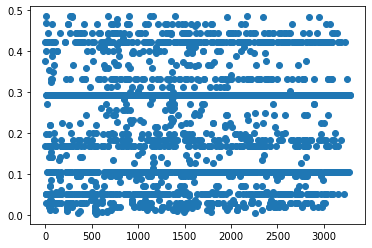

In [286]:
plt.plot(dist_[(dist_ > 0) & (dist_ < .5)], 'o')

##### TF

In [172]:
import tensorflow as tf
 
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [205]:
ratings = tfds.load("movielens/100k-ratings", split="train")

In [206]:
pd.DataFrame([x for x in ratings.take(3).as_numpy_iterator()])

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'


In [207]:
ratings_ = ratings.map(lambda x: {
    'movie_title': x['movie_title'], 
    'user_id': x["user_id"], 
    "user_rating": x["user_rating"],
})

In [208]:
ratings_.element_spec

{'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None),
 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}

In [234]:
list(ratings_.take(3).as_numpy_iterator())

[{'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
  'user_id': b'138',
  'user_rating': 4.0},
 {'movie_title': b'Strictly Ballroom (1992)',
  'user_id': b'92',
  'user_rating': 2.0},
 {'movie_title': b'Very Brady Sequel, A (1996)',
  'user_id': b'301',
  'user_rating': 4.0}]

In [209]:
pd.DataFrame([x for x in ratings_.take(3).as_numpy_iterator()])

,movie_title,user_id,user_rating
0,"b""One Flew Over the Cuckoo's Nest (1975)""",b'138',4.0
1,b'Strictly Ballroom (1992)',b'92',2.0
2,"b'Very Brady Sequel, A (1996)'",b'301',4.0


In [247]:
ratings_

<MapDataset shapes: {movie_title: (), user_id: (), user_rating: ()}, types: {movie_title: tf.string, user_id: tf.string, user_rating: tf.float32}>

In [210]:
tf.random.set_seed(42)
shuffled = ratings_.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [211]:
movie_titles = ratings_.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings_.batch(1_000_000).map(lambda x: x["user_id"])

In [213]:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [216]:
class RankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_movie_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        # Compute predictions.
        self.ratings = tf.keras.Sequential([
          # Learn multiple dense layers.
          tf.keras.layers.Dense(256, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          # Make rating predictions in the final layer.
          tf.keras.layers.Dense(1)
      ])

    def call(self, inputs):
        user_id, movie_title = inputs
        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)
        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [217]:
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03740937]], dtype=float32)>

In [218]:
task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [222]:
from typing import Dict, Text

In [223]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model(
            (features["user_id"], features["movie_title"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)


In [243]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
model.fit(cached_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 18ms/step - root_mean_squared_error: 2.2282 - loss: 4.5481 - regularization_loss: 0.0000e+00 - total_loss: 4.5481
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - root_mean_squared_error: 1.1202 - loss: 1.2483 - regularization_loss: 0.0000e+00 - total_loss: 1.2483
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - root_mean_squared_error: 1.1118 - loss: 1.2363 - regularization_loss: 0.0000e+00 - total_loss: 1.2363
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - root_mean_squared_error: 1.0996 - loss: 1.2069 - regularization_loss: 0.0000e+00 - total_loss: 1.2069
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - root_mean_squared_error: 1.0818 - loss: 1.1679 - regularization_loss: 0.0000e+00 - total_loss: 1.1679
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - root_mean_squared_error: 1.0590 - loss: 1.1200 - regularization_loss: 0.0000e+00 - total

In [227]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.0128 - loss: 1.0241 - regularization_loss: 0.0000e+00 - total_loss: 1.0241


{'root_mean_squared_error': 1.0128363370895386,
 'loss': 1.0166913270950317,
 'regularization_loss': 0,
 'total_loss': 1.0166913270950317}

In [261]:
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

### EXTRACT FEATURES